In [1]:
import cv2
import glob
import scipy.io
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup
import requests

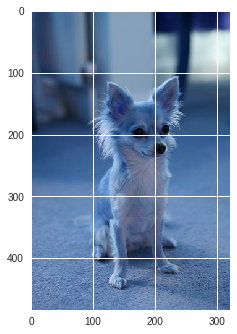

In [2]:
im=cv2.imread('Images/n02085620-Chihuahua/n02085620_10976.jpg')
plt.imshow(im)
plt.show()

In [3]:
def resize(im,desired_size=250):
    old_size = im.shape[:2] 
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    plt.imshow(new_im)
    plt.show()

In [4]:
def resize2(im,desired_size=250):
    old_size = im.shape[:2] 
    ratio = float(desired_size)/min(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im2 = cv2.resize(im, (new_size[1], new_size[0]))
    if im2.shape[0]>250:
        mid=int(im2.shape[0]/2)
        lt=mid-125
        rt=mid+125
        im3=im2[lt:rt,:,:]
    else:
        mid=int(im2.shape[1]/2)
        lt=mid-125
        rt=mid+125
        im3=im2[:,lt:rt,:]
    im4=cv2.resize(im3,(250,250))/255
    return im4

In [6]:
file_type=pd.read_csv('file',header=None,names=['filename','type'])

In [7]:
file_type['breed']=[i.split('/')[0].split('-')[1] for i in file_type.filename.values]

In [8]:
# key is breed name and value is list containing the 10 images
breeds_10=list()
for i in range(1,121):
    breed=dict()
    breed['breed']=file_type['breed'].loc[file_type.type==i].values[0]
    images=np.zeros([250,250,3,10])
    for index, row in file_type.loc[file_type.type==i].iterrows():
        if index>9: 
            break
        else: 
            images[:,:,:,index] = resize2(cv2.imread('Images/'+row['filename']))
    breed['images']=images
    breeds_10.append(breed)

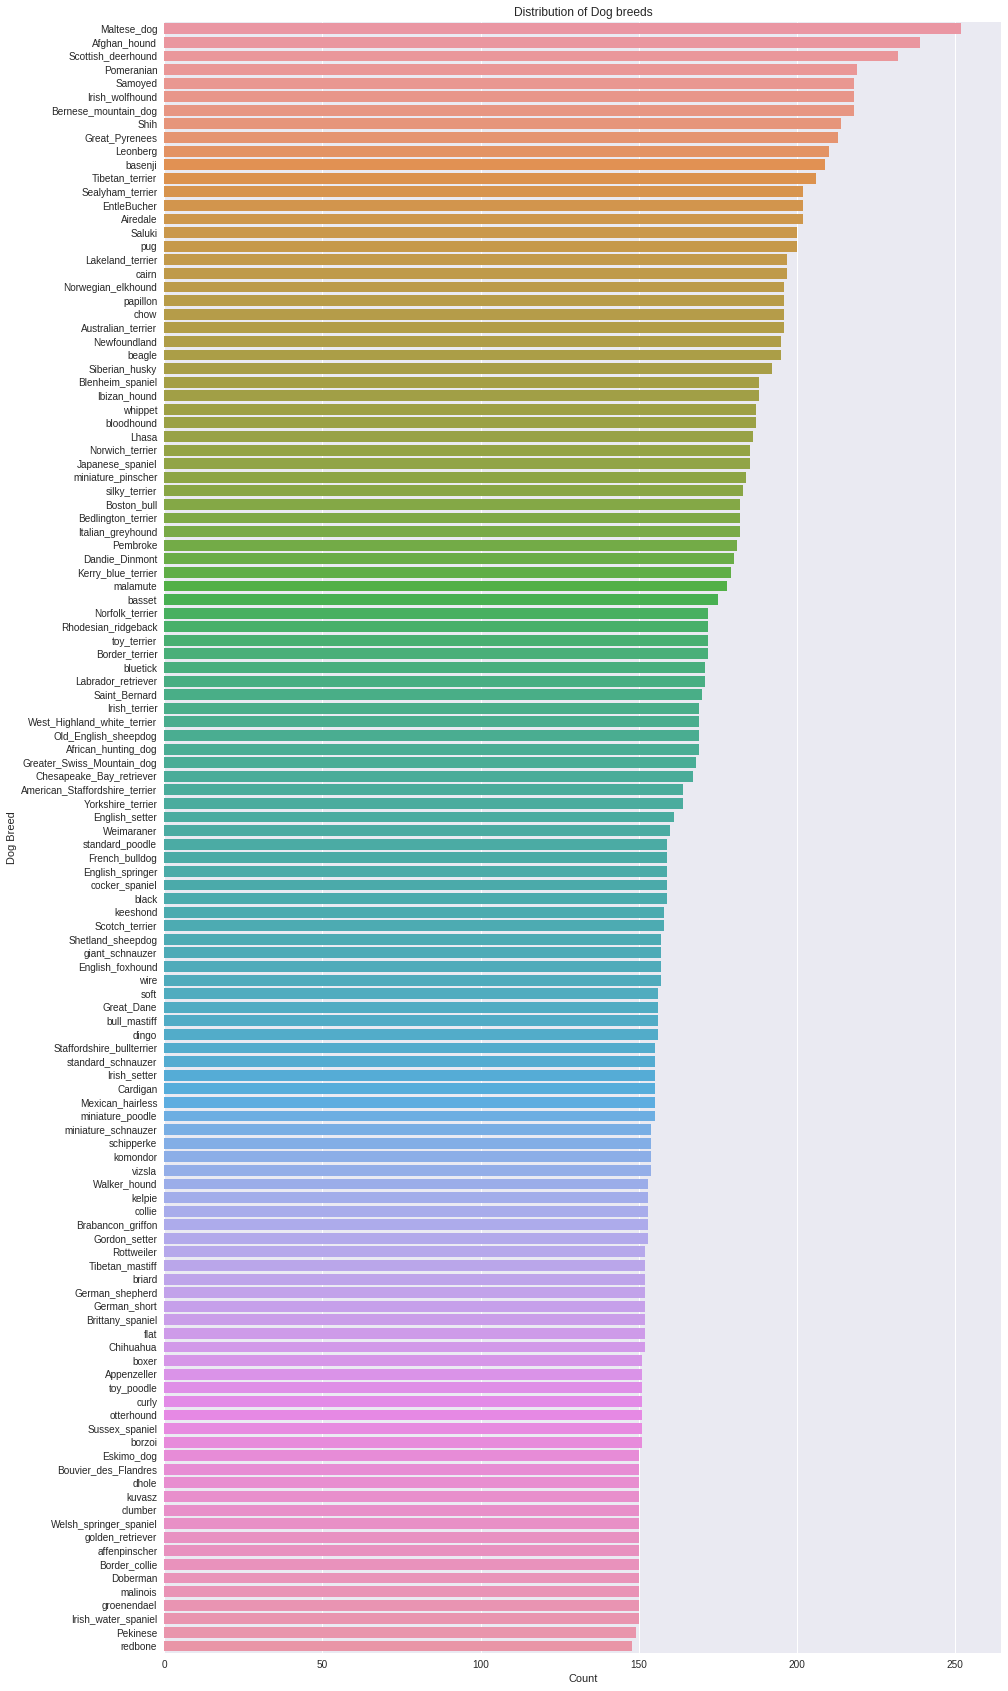

In [9]:
yy=file_type['breed'].value_counts()

fig, ax = plt.subplots()
fig.set_size_inches(15, 30)
sns.set()
ax = sns.barplot(y = yy.index, x = yy, data = file_type,orient='h')
#ax.set_xticklabels(ax.get_yticklabels(), rotation = 90, fontsize = 8)
ax.set(ylabel='Dog Breed', xlabel='Count')
ax.set_title('Distribution of Dog breeds')
plt.savefig('distribution_breeds.png')

In [10]:
yy.head()

Maltese_dog           252
Afghan_hound          239
Scottish_deerhound    232
Pomeranian            219
Samoyed               218
Name: breed, dtype: int64

In [11]:
yy.tail()

malinois               150
groenendael            150
Irish_water_spaniel    150
Pekinese               149
redbone                148
Name: breed, dtype: int64

In [12]:
# Scrape information from AKC website
page = requests.get('https://www.akc.org/dog-breeds/sporting/page/3')
soup = BeautifulSoup(page.content,'html.parser')
name_links = soup.select_one('select."custom-select__select"').select('option')[1:]
group_map = {}
for p in name_links:
    link = p.get('value')
    l_soup = BeautifulSoup(requests.get(link).content,'html.parser')
    group_map[p.text.lower()]=l_soup.select_one('li > span > a').text